## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSSB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
103
+-------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|  36.88280420965144|0.9302361398007852|0.1591972219710314|    152.7|BSBSSSSB| 32.6089| -85.0756|       SNWD|0.9272904811360495|0.9272862359830134|0.9272845486974798|0.9952366993333596|USC00096148|

In [24]:
#extract longitude and latitude for each station
feature='coeff_1'
feature='coeff_2'
feature='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_3 FROM weather
+-----------+--------+---------+---------+--------------------+
|    station|latitude|longitude|elevation|             coeff_3|
+-----------+--------+---------+---------+--------------------+
|USC00096148| 32.6089| -85.0756|    152.7|  0.1591972219710314|
|USC00097087| 32.0467| -84.3711|    152.4|   29.35430759853752|
|USC00016129| 32.6592| -85.4492|    195.1|   10.06641874782651|
|USC00093544| 32.5667| -83.8667|    149.0|0.058720892963780774|
+-----------+--------+---------+---------+--------------------+
only showing top 4 rows



In [25]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
print df2.count()
pdf=df2.toPandas()
#pdf.sort_values(by=['station'],inplace=True)
#pdf.head(2)
pdf.sort_values(by=['latitude'],inplace=True)
pdf.head(38)

38


,station,latitude,longitude,elevation,count(station),avg(coeff_3)
11,USC00092450,31.7672,-84.7931,140.5,2,19.719929
0,USC00011725,31.8708,-85.4500,173.4,2,-68.296316
31,USC00093658,31.8967,-85.0375,149.4,1,0.066415
32,USC00012730,32.0111,-85.0900,70.1,2,0.081866
25,USC00095394,32.0306,-84.7753,147.8,1,0.072453
17,USC00097087,32.0467,-84.3711,152.4,1,29.354308
10,USC00097201,32.0547,-84.5239,123.4,2,0.068535
26,USC00014080,32.2464,-85.4142,122.5,1,0.054176
22,USC00095979,32.2903,-84.0314,99.7,2,0.060511
23,USC00095550,32.4567,-83.9400,54.9,1,0.039655


In [26]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [27]:
min_lat,max_lat,min_long,max_long = box = (31.7672, 33.2833, -85.50, -83.6000)


In [28]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1000*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

Widget Javascript not detected.  It may not be installed or enabled properly.


### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

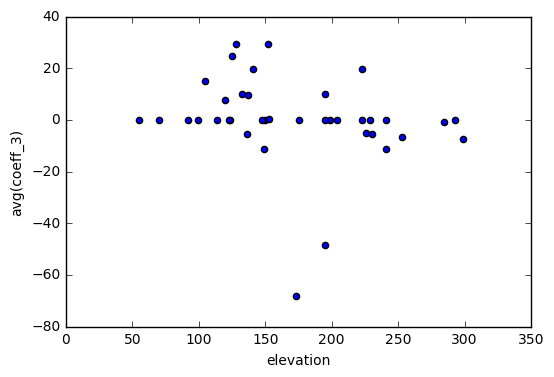

In [29]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_3)');

In [ ]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()